In [1]:
# Imports
import pandas as pd
import numpy as np
from pathlib import Path
import hvplot.pandas
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from pandas.tseries.offsets import DateOffset
from sklearn.metrics import classification_report
import yfinance as yf
from pandas_datareader import data as pdr
from datetime import datetime
from math import floor
from termcolor import colored as cl 


from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

## Generate Dataset
---

In [2]:
# set ticker
ticker = "AAPL"

# set timeframe for data
start = '2015-01-01'
end = '2021-01-01'

# pull historical stock data from 1/10/2005 to 3/8/2021
yf.pdr_override()
stock_data = pdr.get_data_yahoo(ticker, start=start, end=end)

# drop Dividends and Stock Split columns
stock_data = stock_data.drop(columns=['Adj Close'])
stock_data.head()

[*********************100%***********************]  1 of 1 completed


Open       High        Low      Close     Volume
Date                                                             
2015-01-02  27.847500  27.860001  26.837500  27.332500  212818400
2015-01-05  27.072500  27.162500  26.352501  26.562500  257142000
2015-01-06  26.635000  26.857500  26.157499  26.565001  263188400
2015-01-07  26.799999  27.049999  26.674999  26.937500  160423600
2015-01-08  27.307501  28.037500  27.174999  27.972500  237458000

### Filter the dataset

In [3]:
# Filter the date index and close columns
signals_df = stock_data.loc[:, ["Close"]]

# Use the pct_change function to generate  returns from close prices
signals_df["Actual Returns"] = signals_df["Close"].pct_change()

# Drop all NaN values from the DataFrame
signals_df = signals_df.dropna()

# Add in a binary classifier for positive and negative price changes. Set threshold at +/- 0.01%
signals_df['Target'] = (
    (np.where(signals_df['Actual Returns'] > 0.01, 1.0, 0.0)) + 
    (np.where(signals_df['Actual Returns'] < -0.01, -1.0, 0.0))
)

# Review the DataFrame
display(signals_df.head())
display(signals_df.tail())

Close  Actual Returns  Target
Date                                         
2015-01-05  26.562500       -0.028172    -1.0
2015-01-06  26.565001        0.000094     0.0
2015-01-07  26.937500        0.014022     1.0
2015-01-08  27.972500        0.038422     1.0
2015-01-09  28.002501        0.001073     0.0

Close  Actual Returns  Target
Date                                          
2020-12-24  131.970001        0.007712     0.0
2020-12-28  136.690002        0.035766     1.0
2020-12-29  134.869995       -0.013315    -1.0
2020-12-30  133.720001       -0.008527     0.0
2020-12-31  132.690002       -0.007703     0.0

## Generate trading signals
---

### RSI

RSI = 100 – [100 / ( 1 + (EMA_up / EMA_down) ) ] where,

EMAup = Exponential Moving Average of Upward Price Change

EMAdown = Exponential Moving Average of Downward Price Change

In [4]:
# Set RSI trading window
RSI_window = 20

#create new df for bollinger bands
RSI_df = signals_df.copy()

#Create function for RSI calculation
def get_rsi(close, lookback):
    ret = close.diff()
    up = []
    down = []
    for i in range(len(ret)):
        if ret[i] < 0:
            up.append(0)
            down.append(ret[i])
        else:
            up.append(ret[i])
            down.append(0)
    up_series = pd.Series(up)
    down_series = pd.Series(down).abs()
    up_ewm = up_series.ewm(com = lookback - 1, adjust = False).mean()
    down_ewm = down_series.ewm(com = lookback - 1, adjust = False).mean()
    rs = up_ewm/down_ewm
    rsi = 100 - (100 / (1 + rs))
    rsi_df = pd.DataFrame(rsi).rename(columns = {0:'rsi'}).set_index(close.index)
    rsi_df = rsi_df.dropna()
    return rsi_df[3:]

RSI_df [f'rsi_{RSI_window}'] = get_rsi(RSI_df['Close'], RSI_window)
RSI_df = RSI_df.dropna()
RSI_df

Close  Actual Returns  Target      rsi_20
Date                                                      
2015-01-09   28.002501        0.001073     0.0  100.000000
2015-01-12   27.312500       -0.024641    -1.0   65.717569
2015-01-13   27.555000        0.008879     0.0   69.576130
2015-01-14   27.450001       -0.003811     0.0   66.181132
2015-01-15   26.705000       -0.027140    -1.0   48.504279
...                ...             ...     ...         ...
2020-12-24  131.970001        0.007712     0.0   64.470394
2020-12-28  136.690002        0.035766     1.0   68.927308
2020-12-29  134.869995       -0.013315    -1.0   65.587860
2020-12-30  133.720001       -0.008527     0.0   63.540323
2020-12-31  132.690002       -0.007703     0.0   61.723648

[1506 rows x 4 columns]

In [5]:
#RSI Trading Signal

upper_limit = 70
lower_limit = 30


# Calculate rolling mean and standard deviation
RSI_df['RSI_mid_band'] = RSI_df['Close'].rolling(window=RSI_window).mean()
RSI_df['RSI_std'] = RSI_df['Close'].rolling(window=20).std()

# Calculate upper and lowers bands of bollinger band
RSI_df['RSI_upper_band']  = RSI_df['RSI_mid_band'] + (RSI_df['RSI_std'] * 1)
RSI_df['RSI_lower_band']  = RSI_df['RSI_mid_band'] - (RSI_df['RSI_std'] * 1)


# Calculate RSI trading signal
RSI_df['RSI_long'] = np.where(RSI_df['rsi_20'] < lower_limit, 1.0, 0.0)
RSI_df['RSI_short'] = np.where(RSI_df['Close'] > upper_limit, -1.0, 0.0)
RSI_df['RSI_signal'] = RSI_df['RSI_long'] + RSI_df['RSI_short']

    
RSI_df

Close  Actual Returns  Target      rsi_20  RSI_mid_band  \
Date                                                                       
2015-01-09   28.002501        0.001073     0.0  100.000000           NaN   
2015-01-12   27.312500       -0.024641    -1.0   65.717569           NaN   
2015-01-13   27.555000        0.008879     0.0   69.576130           NaN   
2015-01-14   27.450001       -0.003811     0.0   66.181132           NaN   
2015-01-15   26.705000       -0.027140    -1.0   48.504279           NaN   
...                ...             ...     ...         ...           ...   
2020-12-24  131.970001        0.007712     0.0   64.470394    124.903000   
2020-12-28  136.690002        0.035766     1.0   68.927308    125.908001   
2020-12-29  134.869995       -0.013315    -1.0   65.587860    126.699000   
2020-12-30  133.720001       -0.008527     0.0   63.540323    127.249000   
2020-12-31  132.690002       -0.007703     0.0   61.723648    127.729500   

             RSI_std  RSI_upper_band  RSI_lower_band  RSI_long  RSI_short  \
Date                                                                        
2015-01-09       NaN             NaN             NaN       0.0        0.0   
2015-01-12       NaN             NaN             NaN       0.0        0.0   
2015-01-13       NaN             NaN             NaN       0.0        0.0   
2015-01-14       NaN             NaN             NaN       0.0        0.0   
2015-01-15       NaN             NaN             NaN       0.0        0.0   
...              ...             ...             ...       ...        ...   
2020-12-24  4.190395      129.093395      120.712606       0.0       -1.0   
2020-12-28  4.491252      130.399253      121.416748       0.0       -1.0   
2020-12-29  4.611354      131.310355      122.087646       0.0       -1.0   
2020-12-30  4.765221      132.014221      122.483779       0.0       -1.0   
2020-12-31  4.807043      132.536543      122.922457       0.0       -1.0   

            RSI_signal  
Date                    
2015-01-09         0.0  
2015-01-12         0.0  
2015-01-13         0.0  
2015-01-14         0.0  
2015-01-15         0.0  
...                ...  
2020-12-24        -1.0  
2020-12-28        -1.0  
2020-12-29        -1.0  
2020-12-30        -1.0  
2020-12-31        -1.0  

[1506 rows x 11 columns]

<AxesSubplot:xlabel='Date'>

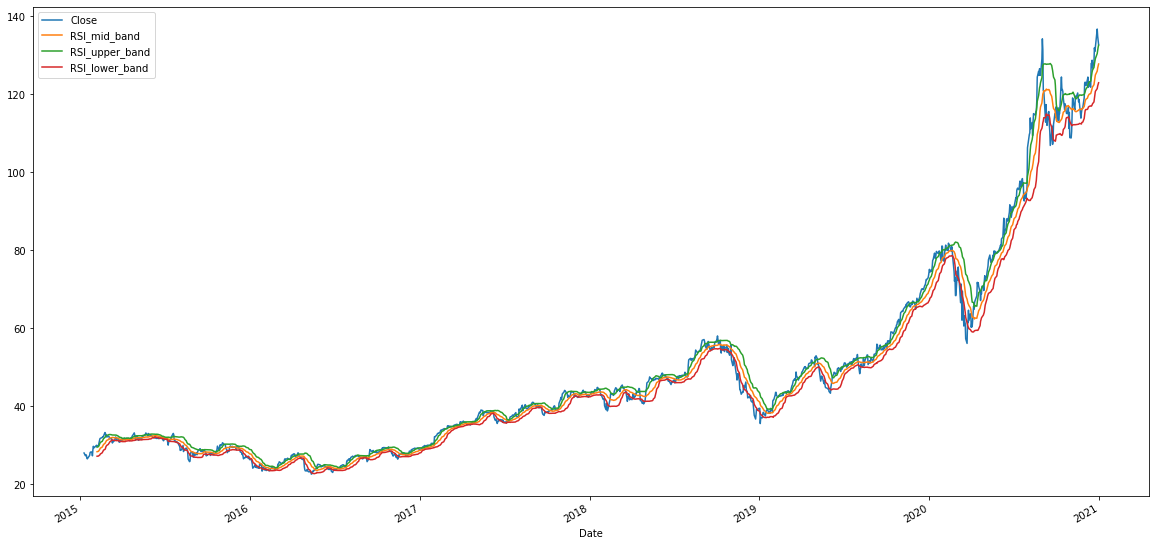

In [6]:
# Plot the RSI for closing prices
RSI_df[['Close','RSI_mid_band','RSI_upper_band','RSI_lower_band']].plot(figsize=(20,10))

In [7]:
# Calculate the strategy returns and add them to the signals_df DataFrame
RSI_df['Strategy Returns'] = RSI_df['Actual Returns'] * RSI_df['RSI_signal'].shift()

# Calculate the points in time at which a position should be taken, 1 or -1
RSI_df['Entry/Exit'] = RSI_df['RSI_signal'].diff()

# # Visualize exit position relative to close price
RSI_df['exit'] = RSI_df[RSI_df['Entry/Exit'] == -1.0]['Close']
RSI_df['entry'] = RSI_df[RSI_df['Entry/Exit'] == 1.0]['Close']

# Review the DataFrame
display(RSI_df.head())
display(RSI_df.tail())

Close  Actual Returns  Target      rsi_20  RSI_mid_band  \
Date                                                                      
2015-01-09  28.002501        0.001073     0.0  100.000000           NaN   
2015-01-12  27.312500       -0.024641    -1.0   65.717569           NaN   
2015-01-13  27.555000        0.008879     0.0   69.576130           NaN   
2015-01-14  27.450001       -0.003811     0.0   66.181132           NaN   
2015-01-15  26.705000       -0.027140    -1.0   48.504279           NaN   

            RSI_std  RSI_upper_band  RSI_lower_band  RSI_long  RSI_short  \
Date                                                                       
2015-01-09      NaN             NaN             NaN       0.0        0.0   
2015-01-12      NaN             NaN             NaN       0.0        0.0   
2015-01-13      NaN             NaN             NaN       0.0        0.0   
2015-01-14      NaN             NaN             NaN       0.0        0.0   
2015-01-15      NaN             NaN             NaN       0.0        0.0   

            RSI_signal  Strategy Returns  Entry/Exit  exit  entry  
Date                                                               
2015-01-09         0.0               NaN         NaN   NaN    NaN  
2015-01-12         0.0              -0.0         0.0   NaN    NaN  
2015-01-13         0.0               0.0         0.0   NaN    NaN  
2015-01-14         0.0              -0.0         0.0   NaN    NaN  
2015-01-15         0.0              -0.0         0.0   NaN    NaN

Close  Actual Returns  Target     rsi_20  RSI_mid_band  \
Date                                                                      
2020-12-24  131.970001        0.007712     0.0  64.470394    124.903000   
2020-12-28  136.690002        0.035766     1.0  68.927308    125.908001   
2020-12-29  134.869995       -0.013315    -1.0  65.587860    126.699000   
2020-12-30  133.720001       -0.008527     0.0  63.540323    127.249000   
2020-12-31  132.690002       -0.007703     0.0  61.723648    127.729500   

             RSI_std  RSI_upper_band  RSI_lower_band  RSI_long  RSI_short  \
Date                                                                        
2020-12-24  4.190395      129.093395      120.712606       0.0       -1.0   
2020-12-28  4.491252      130.399253      121.416748       0.0       -1.0   
2020-12-29  4.611354      131.310355      122.087646       0.0       -1.0   
2020-12-30  4.765221      132.014221      122.483779       0.0       -1.0   
2020-12-31  4.807043      132.536543      122.922457       0.0       -1.0   

            RSI_signal  Strategy Returns  Entry/Exit  exit  entry  
Date                                                               
2020-12-24        -1.0         -0.007712         0.0   NaN    NaN  
2020-12-28        -1.0         -0.035766         0.0   NaN    NaN  
2020-12-29        -1.0          0.013315         0.0   NaN    NaN  
2020-12-30        -1.0          0.008527         0.0   NaN    NaN  
2020-12-31        -1.0          0.007703         0.0   NaN    NaN

### Bollinger Bands

In [8]:
# Set bollinger band window
bollinger_window = 20

#create new df for bollinger bands
bb_df = signals_df.copy()

# Calculate rolling mean and standard deviation
bb_df['bollinger_mid_band'] = bb_df['Close'].rolling(window=bollinger_window).mean()
bb_df['bollinger_std'] = bb_df['Close'].rolling(window=20).std()

# Calculate upper and lowers bands of bollinger band
bb_df['bollinger_upper_band']  = bb_df['bollinger_mid_band'] + (bb_df['bollinger_std'] * 1)
bb_df['bollinger_lower_band']  = bb_df['bollinger_mid_band'] - (bb_df['bollinger_std'] * 1)

# Calculate bollinger band trading signal
bb_df['bollinger_long'] = np.where(bb_df['Close'] < bb_df['bollinger_lower_band'], 1.0, 0.0)
bb_df['bollinger_short'] = np.where(bb_df['Close'] > bb_df['bollinger_upper_band'], -1.0, 0.0)
bb_df['bollinger_signal'] = bb_df['bollinger_long'] + bb_df['bollinger_short']


bb_df

Close  Actual Returns  Target  bollinger_mid_band  \
Date                                                                 
2015-01-05   26.562500       -0.028172    -1.0                 NaN   
2015-01-06   26.565001        0.000094     0.0                 NaN   
2015-01-07   26.937500        0.014022     1.0                 NaN   
2015-01-08   27.972500        0.038422     1.0                 NaN   
2015-01-09   28.002501        0.001073     0.0                 NaN   
...                ...             ...     ...                 ...   
2020-12-24  131.970001        0.007712     0.0          124.903000   
2020-12-28  136.690002        0.035766     1.0          125.908001   
2020-12-29  134.869995       -0.013315    -1.0          126.699000   
2020-12-30  133.720001       -0.008527     0.0          127.249000   
2020-12-31  132.690002       -0.007703     0.0          127.729500   

            bollinger_std  bollinger_upper_band  bollinger_lower_band  \
Date                                                                    
2015-01-05            NaN                   NaN                   NaN   
2015-01-06            NaN                   NaN                   NaN   
2015-01-07            NaN                   NaN                   NaN   
2015-01-08            NaN                   NaN                   NaN   
2015-01-09            NaN                   NaN                   NaN   
...                   ...                   ...                   ...   
2020-12-24       4.190395            129.093395            120.712606   
2020-12-28       4.491252            130.399253            121.416748   
2020-12-29       4.611354            131.310355            122.087646   
2020-12-30       4.765221            132.014221            122.483779   
2020-12-31       4.807043            132.536543            122.922457   

            bollinger_long  bollinger_short  bollinger_signal  
Date                                                           
2015-01-05             0.0              0.0               0.0  
2015-01-06             0.0              0.0               0.0  
2015-01-07             0.0              0.0               0.0  
2015-01-08             0.0              0.0               0.0  
2015-01-09             0.0              0.0               0.0  
...                    ...              ...               ...  
2020-12-24             0.0             -1.0              -1.0  
2020-12-28             0.0             -1.0              -1.0  
2020-12-29             0.0             -1.0              -1.0  
2020-12-30             0.0             -1.0              -1.0  
2020-12-31             0.0             -1.0              -1.0  

[1510 rows x 10 columns]

<AxesSubplot:xlabel='Date'>

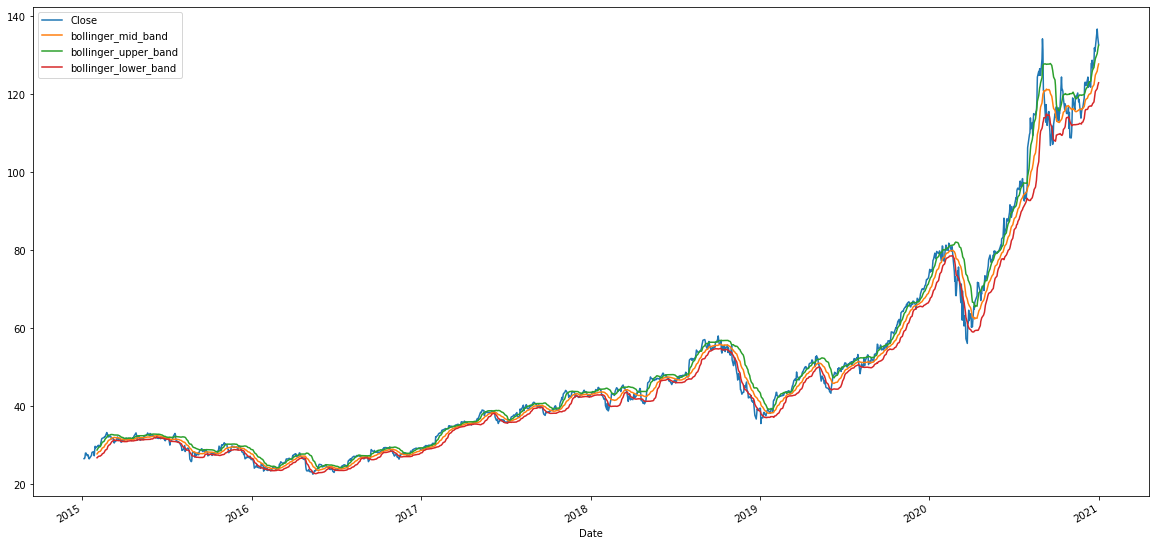

In [9]:
# Plot the Bollinger Bands for closing prices
bb_df[['Close','bollinger_mid_band','bollinger_upper_band','bollinger_lower_band']].plot(figsize=(20,10))

## MACD

In [10]:
val_signals_df = stock_data.loc[:, ["Close"]]

short_window = 1
long_window = 10

# Construct a `Fast` and `Slow` Exponential Moving Average from short and long windows, respectively
val_signals_df['fast_close'] = val_signals_df['Close'].ewm(halflife=short_window).mean()
val_signals_df['slow_close'] = val_signals_df['Close'].ewm(halflife=long_window).mean()

# Construct a crossover trading signal
val_signals_df['crossover_long'] = np.where(val_signals_df['fast_close'] > val_signals_df['slow_close'], 1.0, 0.0)
val_signals_df['crossover_short'] = np.where(val_signals_df['fast_close'] < val_signals_df['slow_close'], -1.0, 0.0)
val_signals_df['crossover_signal'] = val_signals_df['crossover_long'] + val_signals_df['crossover_short']


# Generate the short and long moving averages (50 and 100 days, respectively)
val_signals_df["SMA50"] = val_signals_df["Close"].rolling(window=short_window).mean()
val_signals_df["SMA100"] = val_signals_df["Close"].rolling(window=long_window).mean()
val_signals_df["Signal"] = 0.0

# Generate the trading signal 0 or 1,
# where 0 is when the SMA50 is under the SMA100, and
# where 1 is when the SMA50 is higher (or crosses over) the SMA100
val_signals_df["Signal"][short_window:] = np.where(
    val_signals_df["SMA50"][short_window:] > val_signals_df["SMA100"][short_window:], 1.0, 0.0
)

# Calculate the points in time at which a position should be taken, 1 or -1
val_signals_df["Entry/Exit"] = val_signals_df["Signal"].diff()

val_signals_df.head(10)

Close  fast_close  slow_close  crossover_long  \
Date                                                            
2015-01-02  27.332500   27.332500   27.332500             0.0   
2015-01-05  26.562500   26.819167   26.934162             0.0   
2015-01-06  26.565001   26.673929   26.802487             0.0   
2015-01-07  26.937500   26.814500   26.839827             0.0   
2015-01-08  27.972500   27.412177   27.098801             1.0   
2015-01-09  28.002501   27.712024   27.276666             1.0   
2015-01-12  27.312500   27.510689   27.282909             1.0   
2015-01-13  27.555000   27.532932   27.325716             1.0   
2015-01-14  27.450001   27.491385   27.343649             1.0   
2015-01-15  26.705000   27.097808   27.258112             0.0   

            crossover_short  crossover_signal      SMA50   SMA100  Signal  \
Date                                                                        
2015-01-02              0.0               0.0  27.332500      NaN     0.0   
2015-01-05             -1.0              -1.0  26.562500      NaN     0.0   
2015-01-06             -1.0              -1.0  26.565001      NaN     0.0   
2015-01-07             -1.0              -1.0  26.937500      NaN     0.0   
2015-01-08              0.0               1.0  27.972500      NaN     0.0   
2015-01-09              0.0               1.0  28.002501      NaN     0.0   
2015-01-12              0.0               1.0  27.312500      NaN     0.0   
2015-01-13              0.0               1.0  27.555000      NaN     0.0   
2015-01-14              0.0               1.0  27.450001      NaN     0.0   
2015-01-15             -1.0              -1.0  26.705000  27.2395     0.0   

            Entry/Exit  
Date                    
2015-01-02         NaN  
2015-01-05         0.0  
2015-01-06         0.0  
2015-01-07         0.0  
2015-01-08         0.0  
2015-01-09         0.0  
2015-01-12         0.0  
2015-01-13         0.0  
2015-01-14         0.0  
2015-01-15         0.0

In [11]:
# Visualize exit position relative to close price
exit = val_signals_df[val_signals_df['Entry/Exit'] == -1.0]['Close'].hvplot.scatter(
    color='red',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize entry position relative to close price
entry = val_signals_df[val_signals_df['Entry/Exit'] == 1.0]['Close'].hvplot.scatter(
    color='green',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize close price for the investment
security_close = val_signals_df[['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize moving averages
moving_avgs = val_signals_df[['SMA50', 'SMA100']].hvplot(
    ylabel='Price in $',
    width=1000,
    height=400)

# Overlay plots
entry_exit_plot = security_close * moving_avgs * entry * exit
entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

## SMA

In [22]:
# Set the windows
short_window = 50
long_window = 100

sma_df = signals_df.copy()

# Generate the short (50 days) and long moving averages(100 days) 
sma_df["SMA50"] = sma_df["Close"].rolling(window=short_window).mean()
sma_df["SMA100"] = trading_signals["Close"].rolling(window=long_window).mean()
sma_df["Signal"] = 0.0

# Generate the trading signal 0 or 1,
# where 0 is when the SMA50 is under the SMA100, and
# where 1 is when the SMA50 is higher (or crosses over) the SMA100
sma_df["Signal"][short_window:] = np.where(
    sma_df["SMA50"][short_window:] > sma_df["SMA100"][short_window:], 1.0, 0.0
)

# Calculate the points in time at which a position should be taken, 1 or -1
sma_df["Entry/Exit"] = sma_df["Signal"].diff()


# Visualize exit point compared to closing price
exit = sma_df[sma_df['Entry/Exit'] == -1.0]['Close'].hvplot.scatter(
    color='red',
    legend=False,
    ylabel='Price in USD $',
    width=1100,
    height=600
)
# Visualize entry point compared to the closing price
entry = sma_df[sma_df['Entry/Exit'] == 1.0]['Close'].hvplot.scatter(
    color='green',
    legend=False,
    ylabel='Price in USD $',
    width=1100,
    height=600
)
# Visualize closing price
close_price = sma_df[['Close']].hvplot(
    line_color='lightblue',
    ylabel='Closing Price in USD $',
    width=1100,
    height=600
)
# Visualize moving averages
mv_avgs = sma_df[['SMA50', 'SMA100']].hvplot(
    ylabel='Closing Price in USD $',
    width=1100,
    height=600
)
# Generate the plots
entry_exit_plot = close_price * mv_avgs * entry * exit
entry_exit_plot.opts(xaxis=True)


:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

## MACD

In [29]:
MACD_df = signals_df.copy()

# Calulate the Short and Long EMA
EMA_short = trading_signals.Close.ewm(span=12, adjust=False).mean()
EMA_long = trading_signals.Close.ewm(span=24, adjust=False).mean()

# Calculate the MACD
MACD = EMA_short - EMA_long

signal = MACD.ewm(span=9, adjust=False).mean()


MACD_df["MACD"] = MACD
MACD_df["Signal"] = signal
MACD_df

def entry_exit(signal):
    Entry = []
    Exit = []
    flag = -1
    
    for i in range(0, len(signal)):
        if signal["MACD"][i] > signal["Signal"][i]:
            Exit.append(np.nan)
            if flag != 1:
                Entry.append(signal["Close"][i])
                flag = 1
            else:
                Entry.append(np.nan)
        elif signal["MACD"][i] < signal["Signal"][i]:
            Entry.append(np.nan)
            if flag != 0:
                Exit.append(signal["Close"][i])
                flag = 0
            else:
                Exit.append(np.nan)
        else:
            Entry.append(np.nan)
            Exit.append(np.nan)
            
    return (Entry, Exit, flag)

data = entry_exit(trading_signals)
MACD_df["Entry_Point"] = data[0]
MACD_df["Exit_Point"] = data[1]
MACD_df["flag"] = data[2]



MACD_df['MACD Entry/Exit'] = MACD_df['Signal'].diff()

MACD_df.where(~MACD_df.notna(), 1) 

# MACD_df['flag'].value_counts()
MACD_df

ValueError: Length of values (1510) does not match length of index (1506)

### Compiling Signals

In [15]:
master_df = signals_df.join(RSI_df, lsuffix='RSI', rsuffix='BB').join(bb_df, lsuffix='RSI', rsuffix='BB').join(val_signals_df, lsuffix='BB', rsuffix='SMA').join(trading_signals, lsuffix='RSI', rsuffix='MACD')
master_df.head()

In [30]:
# Compiling Signals
signals = []
    
# Bollinger Bands
col_name = 'BB_signal'
signals_df[col_name] = bb_df['bollinger_signal']
signals.append(col_name)


# RSI
col_name = 'RSI_signal'
signals_df[col_name] = RSI_df['RSI_signal']
signals.append(col_name)

#SMA
col_name = 'SMA_signal'
signals_df[col_name] = sma_df['Entry/Exit']
signals.append(col_name)


#MACD
# col_name = 'MACD_signal'
# signals_df[col_name] = MACD_df['MACD Entry/Exit']
# signals.append(col_name)


signals

['BB_signal', 'RSI_signal', 'SMA_signal']

In [31]:
# Removing nan values
signals_df.dropna(inplace=True)

In [32]:
signals_df[signals+['Target']]

BB_signal  RSI_signal  SMA_signal  Target
Date                                                 
2015-01-09        0.0         0.0         0.0     0.0
2015-01-12        0.0         0.0         0.0    -1.0
2015-01-13        0.0         0.0         0.0     0.0
2015-01-14        0.0         0.0         0.0     0.0
2015-01-15        0.0         0.0         0.0    -1.0
...               ...         ...         ...     ...
2020-12-24       -1.0        -1.0         0.0     0.0
2020-12-28       -1.0        -1.0         0.0     1.0
2020-12-29       -1.0        -1.0         0.0    -1.0
2020-12-30       -1.0        -1.0         0.0     0.0
2020-12-31       -1.0        -1.0         0.0     0.0

[1506 rows x 4 columns]

### Visualize Relationship Among Signals

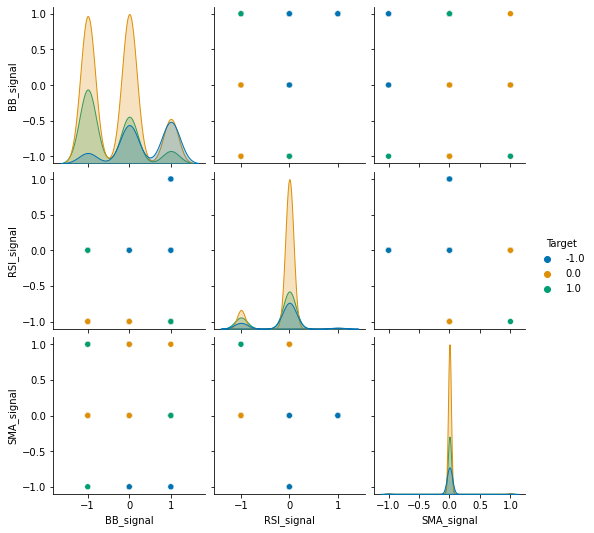

In [33]:
# use pairplots to visualize strength of signals 
sns.pairplot(signals_df[signals+['Target']],hue='Target',palette='colorblind')

## Prepare the Machine Learning Models
---

### Split the data into training and testing datasets

In [34]:
# Assign Target column to a features DataFrame called X
X = signals_df[signals].iloc[:-1]

# Review the DataFrame
X.tail()

BB_signal  RSI_signal  SMA_signal
Date                                         
2020-12-23       -1.0        -1.0         0.0
2020-12-24       -1.0        -1.0         0.0
2020-12-28       -1.0        -1.0         0.0
2020-12-29       -1.0        -1.0         0.0
2020-12-30       -1.0        -1.0         0.0

In [35]:
# Create the target set selecting the Signal column and assiging it to y
y = signals_df.iloc[:-1]['Target']

# Review the value counts
y.value_counts()

 0.0    851
 1.0    376
-1.0    278
Name: Target, dtype: int64

In [36]:
from sklearn.model_selection import train_test_split

# Split dataset into training set and test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3) # 70% training and 30% test


# X_train.shape, y_train.shape,X_test.shape, y_test.shape

X_train.head()

BB_signal  RSI_signal  SMA_signal
Date                                         
2017-08-28       -1.0         0.0         0.0
2019-09-04        0.0         0.0         0.0
2018-10-26        1.0         0.0         0.0
2015-11-25        0.0         0.0         0.0
2015-12-01        0.0         0.0         0.0

In [37]:
#scale the data w/ minmax scaler as all obersvations are in range [-1.1]
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

X_train_scaled_df = pd.DataFrame(X_train_scaled,columns=X_train.columns)

In [38]:
X_train_scaled_df.describe().T.round(2)

count  mean   std  min  25%  50%  75%  max
BB_signal   1053.0  0.38  0.37  0.0  0.0  0.5  0.5  1.0
RSI_signal  1053.0  0.43  0.18  0.0  0.5  0.5  0.5  1.0
SMA_signal  1053.0  0.50  0.05  0.0  0.5  0.5  0.5  1.0

# Logistic Regression

In [39]:
from sklearn.linear_model import LogisticRegression

# Create model
model = LogisticRegression()

# Train model
model.fit(X_train, y_train)

LogisticRegression()

In [40]:
# Predict on train dataset
y_pred_train = model.predict(X_train_scaled)
# Predict on test dataset
y_pred = model.predict(X_test_scaled)

## Model Evaluation

In [41]:
from sklearn.metrics import accuracy_score

#Scoring the model
print('Model accuracy on training data:', accuracy_score(y_train, y_pred_train))
print('Model accuracy on testing data:', accuracy_score(y_test, y_pred))

# Printing classification report
print(classification_report(y_test, y_pred))

Model accuracy on training data: 0.5783475783475783
Model accuracy on testing data: 0.5619469026548672
              precision    recall  f1-score   support

        -1.0       0.33      0.02      0.05        82
         0.0       0.57      1.00      0.72       253
         1.0       0.00      0.00      0.00       117

    accuracy                           0.56       452
   macro avg       0.30      0.34      0.26       452
weighted avg       0.38      0.56      0.41       452



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Backtesting

In [42]:
# Create a new empty predictions DataFrame.
predictions_df = pd.DataFrame(columns = ['Date','Predicted', 'Target', 'Actual Returns', 'Strategy Returns'])
predictions_df

Empty DataFrame
Columns: [Date, Predicted, Target, Actual Returns, Strategy Returns]
Index: []

In [43]:
predictions_df['Date'] = y_test
predictions_df.drop(columns=['Date'])

# Add the model predictions to the DataFrame
predictions_df['Predicted'] = y_pred


# Add the model predictions to the DataFrame
predictions_df['Target']=signals_df['Target']
predictions_df

# Add the actual returns to the DataFrame
predictions_df['Actual Returns'] = signals_df['Actual Returns']
predictions_df

# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = predictions_df['Actual Returns'] * predictions_df['Predicted'].shift()
predictions_df

# Add the strategy returns to the DataFrame
predictions_df['Close'] = signals_df['Close']
predictions_df

# Calculate the points in time at which a position should be taken, 1 or -1
predictions_df['Entry/Exit'] = predictions_df['Predicted'].diff()


predictions_df

Date  Predicted  Target  Actual Returns  Strategy Returns  \
Date                                                                    
2018-06-05   0.0        0.0     0.0        0.007715               NaN   
2018-02-12   1.0        0.0     1.0        0.040279               0.0   
2015-02-18   0.0        0.0     0.0        0.006962               0.0   
2018-05-11   0.0        0.0     0.0       -0.007630              -0.0   
2018-12-27   0.0        0.0     0.0       -0.006490              -0.0   
...          ...        ...     ...             ...               ...   
2016-09-22   0.0        0.0     0.0        0.009423               0.0   
2018-06-12   0.0        0.0     0.0        0.005491               0.0   
2020-11-19   0.0        0.0     0.0        0.005168               0.0   
2019-06-20   0.0        0.0     0.0        0.008036               0.0   
2020-02-07  -1.0        0.0    -1.0       -0.015928              -0.0   

                 Close  Entry/Exit  
Date                                
2018-06-05   48.327499         NaN  
2018-02-12   40.677502         0.0  
2015-02-18   32.180000         0.0  
2018-05-11   47.147499         0.0  
2018-12-27   39.037498         0.0  
...                ...         ...  
2016-09-22   28.655001         0.0  
2018-06-12   48.070000         0.0  
2020-11-19  118.639999         0.0  
2019-06-20   49.865002         0.0  
2020-02-07   80.007500         0.0  

[452 rows x 7 columns]

In [44]:
# Visualize exit position relative to close price
exit = predictions_df[predictions_df['Entry/Exit'] == -1.0]['Close'].hvplot.scatter(
    color='red',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize entry position relative to close price
entry = predictions_df[predictions_df['Entry/Exit'] == 1.0]['Close'].hvplot.scatter(
    color='green',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize close price for the investment
security_close = predictions_df[['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400)

# Overlay plots
entry_exit_plot = security_close  * entry * exit
entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

## Strategy Returns

This trading algorithm has returned 453.54121726782375% from 2015-01-21 00:00:00 to 2020-12-30 00:00:00


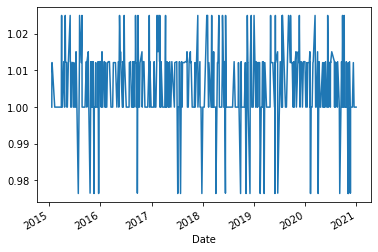

In [45]:
# Plot Cum Returns of Strategy
cumulative_rtns = (1 + predictions_df['Strategy Returns']).cumprod()
cumulative_rtns.plot()

alpha = ((1 + predictions_df['Strategy Returns']).cumprod().mean()) - ((predictions_df['Actual Returns']).cumprod().mean())
series_begin = predictions_df.index.min()
series_end = predictions_df.index.max()

print(f'This trading algorithm has returned {cumulative_rtns.sum()}% from {series_begin} to {series_end}')

## ADABoostClassifier

In [46]:
from sklearn.ensemble import AdaBoostClassifier

# Create model
model = AdaBoostClassifier()

# Train model
model.fit(X_train_scaled, y_train)

AdaBoostClassifier()

In [47]:
# Predict on train dataset
y_pred_train = model.predict(X_train_scaled)
# Predict on test dataset
y_pred = model.predict(X_test_scaled)

In [48]:
#Scoring the model
print('Model accuracy on training data:', accuracy_score(y_train, y_pred_train))
print('Model accuracy on testing data:', accuracy_score(y_test, y_pred))

# Printing classification report
print(classification_report(y_test, y_pred))

Model accuracy on training data: 0.5698005698005698
Model accuracy on testing data: 0.5641592920353983
              precision    recall  f1-score   support

        -1.0       0.43      0.60      0.50        82
         0.0       0.63      0.75      0.68       253
         1.0       0.45      0.15      0.22       117

    accuracy                           0.56       452
   macro avg       0.50      0.50      0.47       452
weighted avg       0.55      0.56      0.53       452



## Backtesting

In [49]:
# Create a new empty predictions DataFrame.
predictions_df = pd.DataFrame(columns = ['Date','Predicted', 'Target', 'Actual Returns', 'Strategy Returns'])
predictions_df

Empty DataFrame
Columns: [Date, Predicted, Target, Actual Returns, Strategy Returns]
Index: []

In [50]:
predictions_df['Date'] = y_test
predictions_df.drop(columns=['Date'])

# Add the model predictions to the DataFrame
predictions_df['Predicted'] = y_pred


# Add the model predictions to the DataFrame
predictions_df['Target']=signals_df['Target']
predictions_df

# Add the actual returns to the DataFrame
predictions_df['Actual Returns'] = signals_df['Actual Returns']
predictions_df

# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = predictions_df['Actual Returns'] * predictions_df['Predicted'].shift()
predictions_df

# Add the strategy returns to the DataFrame
predictions_df['Close'] = signals_df['Close']
predictions_df

# Calculate the points in time at which a position should be taken, 1 or -1
predictions_df['Entry/Exit'] = predictions_df['Predicted'].diff()


predictions_df

Date  Predicted  Target  Actual Returns  Strategy Returns  \
Date                                                                    
2018-06-05   0.0        0.0     0.0        0.007715               NaN   
2018-02-12   1.0        0.0     1.0        0.040279          0.000000   
2015-02-18   0.0        0.0     0.0        0.006962          0.000000   
2018-05-11   0.0        0.0     0.0       -0.007630         -0.000000   
2018-12-27   0.0       -1.0     0.0       -0.006490         -0.000000   
...          ...        ...     ...             ...               ...   
2016-09-22   0.0        0.0     0.0        0.009423          0.000000   
2018-06-12   0.0        0.0     0.0        0.005491          0.000000   
2020-11-19   0.0       -1.0     0.0        0.005168          0.000000   
2019-06-20   0.0        0.0     0.0        0.008036         -0.008036   
2020-02-07  -1.0       -1.0    -1.0       -0.015928         -0.000000   

                 Close  Entry/Exit  
Date                                
2018-06-05   48.327499         NaN  
2018-02-12   40.677502         0.0  
2015-02-18   32.180000         0.0  
2018-05-11   47.147499         0.0  
2018-12-27   39.037498        -1.0  
...                ...         ...  
2016-09-22   28.655001         0.0  
2018-06-12   48.070000         0.0  
2020-11-19  118.639999        -1.0  
2019-06-20   49.865002         1.0  
2020-02-07   80.007500        -1.0  

[452 rows x 7 columns]

In [51]:
# Visualize exit position relative to close price
exit = predictions_df[predictions_df['Entry/Exit'] == -1.0]['Close'].hvplot.scatter(
    color='red',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize entry position relative to close price
entry = predictions_df[predictions_df['Entry/Exit'] == 1.0]['Close'].hvplot.scatter(
    color='green',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize close price for the investment
security_close = predictions_df[['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400)

# Overlay plots
entry_exit_plot = security_close  * entry * exit
entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

## Strategy Returns

This trading algorithm has returned 442.94202869609876% from 2015-01-21 00:00:00 to 2020-12-30 00:00:00


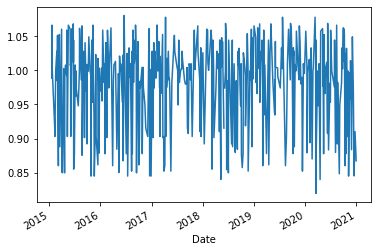

In [52]:
# Plot Cum Returns of Strategy
cumulative_rtns = (1 + predictions_df['Strategy Returns']).cumprod()
cumulative_rtns.plot()

alpha = ((1 + predictions_df['Strategy Returns']).cumprod().mean()) - ((predictions_df['Actual Returns']).cumprod().mean())
series_begin = predictions_df.index.min()
series_end = predictions_df.index.max()

print(f'This trading algorithm has returned {cumulative_rtns.sum()}% from {series_begin} to {series_end}')

# DecisionTree Classifier

In [53]:
from sklearn.tree import DecisionTreeClassifier

# Create model
model = DecisionTreeClassifier()

# Train model
model.fit(X_train_scaled, y_train)

DecisionTreeClassifier()

In [54]:
# Predict on train dataset
y_pred_train = model.predict(X_train_scaled)
# Predict on test dataset
y_pred = model.predict(X_test_scaled)

In [55]:
#Scoring the model
print('Model accuracy on training data:', accuracy_score(y_train, y_pred_train))
print('Model accuracy on testing data:', accuracy_score(y_test, y_pred))

# Printing classification report
print(classification_report(y_test, y_pred))

Model accuracy on training data: 0.5830959164292497
Model accuracy on testing data: 0.5641592920353983
              precision    recall  f1-score   support

        -1.0       0.45      0.49      0.47        82
         0.0       0.59      0.85      0.70       253
         1.0       0.00      0.00      0.00       117

    accuracy                           0.56       452
   macro avg       0.35      0.45      0.39       452
weighted avg       0.41      0.56      0.48       452



/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/anaconda3/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1245: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


## Backtesting

In [56]:
# Create a new empty predictions DataFrame.
predictions_df = pd.DataFrame(columns = ['Date','Predicted', 'Target', 'Actual Returns', 'Strategy Returns'])
predictions_df

Empty DataFrame
Columns: [Date, Predicted, Target, Actual Returns, Strategy Returns]
Index: []

In [57]:
predictions_df['Date'] = y_test
predictions_df.drop(columns=['Date'])

# Add the model predictions to the DataFrame
predictions_df['Predicted'] = y_pred


# Add the model predictions to the DataFrame
predictions_df['Target']=signals_df['Target']
predictions_df

# Add the actual returns to the DataFrame
predictions_df['Actual Returns'] = signals_df['Actual Returns']
predictions_df

# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = predictions_df['Actual Returns'] * predictions_df['Predicted'].shift()
predictions_df

# Add the strategy returns to the DataFrame
predictions_df['Close'] = signals_df['Close']
predictions_df

# Calculate the points in time at which a position should be taken, 1 or -1
predictions_df['Entry/Exit'] = predictions_df['Predicted'].diff()


predictions_df

Date  Predicted  Target  Actual Returns  Strategy Returns  \
Date                                                                    
2018-06-05   0.0        0.0     0.0        0.007715               NaN   
2018-02-12   1.0        0.0     1.0        0.040279               0.0   
2015-02-18   0.0        0.0     0.0        0.006962               0.0   
2018-05-11   0.0        0.0     0.0       -0.007630              -0.0   
2018-12-27   0.0       -1.0     0.0       -0.006490              -0.0   
...          ...        ...     ...             ...               ...   
2016-09-22   0.0        0.0     0.0        0.009423               0.0   
2018-06-12   0.0        0.0     0.0        0.005491               0.0   
2020-11-19   0.0        0.0     0.0        0.005168               0.0   
2019-06-20   0.0        0.0     0.0        0.008036               0.0   
2020-02-07  -1.0        0.0    -1.0       -0.015928              -0.0   

                 Close  Entry/Exit  
Date                                
2018-06-05   48.327499         NaN  
2018-02-12   40.677502         0.0  
2015-02-18   32.180000         0.0  
2018-05-11   47.147499         0.0  
2018-12-27   39.037498        -1.0  
...                ...         ...  
2016-09-22   28.655001         0.0  
2018-06-12   48.070000         0.0  
2020-11-19  118.639999         0.0  
2019-06-20   49.865002         0.0  
2020-02-07   80.007500         0.0  

[452 rows x 7 columns]

In [58]:
# Visualize exit position relative to close price
exit = predictions_df[predictions_df['Entry/Exit'] == -1.0]['Close'].hvplot.scatter(
    color='red',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize entry position relative to close price
entry = predictions_df[predictions_df['Entry/Exit'] == 1.0]['Close'].hvplot.scatter(
    color='green',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize close price for the investment
security_close = predictions_df[['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400)

# Overlay plots
entry_exit_plot = security_close  * entry * exit
entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

## Strategy Returns

This trading algorithm has returned 428.0421642473376% from 2015-01-21 00:00:00 to 2020-12-30 00:00:00


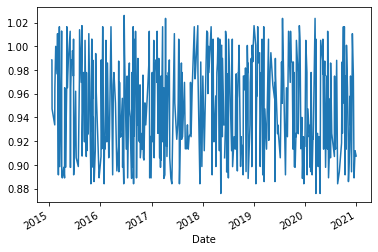

In [59]:
# Plot Cum Returns of Strategy
cumulative_rtns = (1 + predictions_df['Strategy Returns']).cumprod()
cumulative_rtns.plot()

alpha = ((1 + predictions_df['Strategy Returns']).cumprod().mean()) - ((predictions_df['Actual Returns']).cumprod().mean())
series_begin = predictions_df.index.min()
series_end = predictions_df.index.max()

print(f'This trading algorithm has returned {cumulative_rtns.sum()}% from {series_begin} to {series_end}')

# Gradient Boosting Classifier

In [60]:
from sklearn.ensemble import GradientBoostingClassifier

# Create model
model = GradientBoostingClassifier()

# Train model
model.fit(X_train_scaled, y_train)

GradientBoostingClassifier()

In [61]:
# Predict on train dataset
y_pred_train = model.predict(X_train_scaled)
# Predict on test dataset
y_pred = model.predict(X_test_scaled)

In [62]:
#Scoring the model
print('Model accuracy on training data:', accuracy_score(y_train, y_pred_train))
print('Model accuracy on testing data:', accuracy_score(y_test, y_pred))

# Printing classification report
print(classification_report(y_test, y_pred))

Model accuracy on training data: 0.5830959164292497
Model accuracy on testing data: 0.5619469026548672
              precision    recall  f1-score   support

        -1.0       0.45      0.49      0.47        82
         0.0       0.61      0.81      0.70       253
         1.0       0.32      0.08      0.12       117

    accuracy                           0.56       452
   macro avg       0.46      0.46      0.43       452
weighted avg       0.51      0.56      0.51       452



## Backtesting

In [63]:
# Create a new empty predictions DataFrame.
predictions_df = pd.DataFrame(columns = ['Date','Predicted', 'Target', 'Actual Returns', 'Strategy Returns'])
predictions_df

Empty DataFrame
Columns: [Date, Predicted, Target, Actual Returns, Strategy Returns]
Index: []

In [64]:
predictions_df['Date'] = y_test
predictions_df.drop(columns=['Date'])

# Add the model predictions to the DataFrame
predictions_df['Predicted'] = y_pred


# Add the model predictions to the DataFrame
predictions_df['Target']=signals_df['Target']
predictions_df

# Add the actual returns to the DataFrame
predictions_df['Actual Returns'] = signals_df['Actual Returns']
predictions_df

# Add the strategy returns to the DataFrame
predictions_df['Strategy Returns'] = predictions_df['Actual Returns'] * predictions_df['Predicted'].shift()
predictions_df

# Add the strategy returns to the DataFrame
predictions_df['Close'] = signals_df['Close']
predictions_df

# Calculate the points in time at which a position should be taken, 1 or -1
predictions_df['Entry/Exit'] = predictions_df['Predicted'].diff()


predictions_df

Date  Predicted  Target  Actual Returns  Strategy Returns  \
Date                                                                    
2018-06-05   0.0        0.0     0.0        0.007715               NaN   
2018-02-12   1.0        0.0     1.0        0.040279          0.000000   
2015-02-18   0.0        0.0     0.0        0.006962          0.000000   
2018-05-11   0.0        0.0     0.0       -0.007630         -0.000000   
2018-12-27   0.0       -1.0     0.0       -0.006490         -0.000000   
...          ...        ...     ...             ...               ...   
2016-09-22   0.0        0.0     0.0        0.009423          0.000000   
2018-06-12   0.0        0.0     0.0        0.005491          0.000000   
2020-11-19   0.0        1.0     0.0        0.005168          0.000000   
2019-06-20   0.0        0.0     0.0        0.008036          0.008036   
2020-02-07  -1.0        1.0    -1.0       -0.015928         -0.000000   

                 Close  Entry/Exit  
Date                                
2018-06-05   48.327499         NaN  
2018-02-12   40.677502         0.0  
2015-02-18   32.180000         0.0  
2018-05-11   47.147499         0.0  
2018-12-27   39.037498        -1.0  
...                ...         ...  
2016-09-22   28.655001         0.0  
2018-06-12   48.070000         0.0  
2020-11-19  118.639999         1.0  
2019-06-20   49.865002        -1.0  
2020-02-07   80.007500         1.0  

[452 rows x 7 columns]

In [65]:
# Visualize exit position relative to close price
exit = predictions_df[predictions_df['Entry/Exit'] == -1.0]['Close'].hvplot.scatter(
    color='red',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize entry position relative to close price
entry = predictions_df[predictions_df['Entry/Exit'] == 1.0]['Close'].hvplot.scatter(
    color='green',
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400)

# Visualize close price for the investment
security_close = predictions_df[['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400)

# Overlay plots
entry_exit_plot = security_close  * entry * exit
entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .Scatter.Close.II :Scatter   [Date]   (Close)

## Strategy Returns

This trading algorithm has returned 409.88817716123214% from 2015-01-21 00:00:00 to 2020-12-30 00:00:00


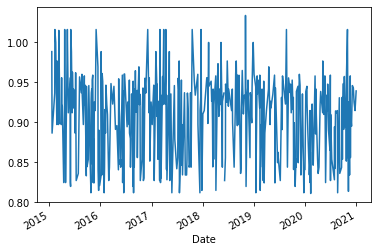

In [66]:
# Plot Cum Returns of Strategy
cumulative_rtns = (1 + predictions_df['Strategy Returns']).cumprod()
cumulative_rtns.plot()

alpha = ((1 + predictions_df['Strategy Returns']).cumprod().mean()) - ((predictions_df['Actual Returns']).cumprod().mean())
series_begin = predictions_df.index.min()
series_end = predictions_df.index.max()

print(f'This trading algorithm has returned {cumulative_rtns.sum()}% from {series_begin} to {series_end}')

# Evaluation
___

## Prep Evaluation Metrics Dataframe

In [67]:
# Prepare DataFrame for metrics
metrics = [
    'Annual Return',
    'Cumulative Returns',
    'Annual Volatility',
    'Sharpe Ratio',
    'Sortino Ratio']

columns = ['Backtest']

# Initialize the DataFrame with index set to evaluation metrics and column = trading staregy
portfolio_evaluation_df = pd.DataFrame(index=metrics, columns=columns)
portfolio_evaluation_df

Backtest
Annual Return           NaN
Cumulative Returns      NaN
Annual Volatility       NaN
Sharpe Ratio            NaN
Sortino Ratio           NaN

## Calculate and Assign Portfolio Metrics

In [141]:
# Calculate cumulative return
portfolio_evaluation_df.loc['Cumulative Returns'] = _df['Portfolio Cumulative Returns'][-1]

# Calculate annualized return
portfolio_evaluation_df.loc['Annual Return'] = (
    master_df['Portfolio Daily Returns'].mean() * 252
)

# Calculate annual volatility
portfolio_evaluation_df.loc['Annual Volatility'] = (
    master_df['Portfolio Daily Returns'].std() * np.sqrt(252)
)

# Calculate Sharpe Ratio
portfolio_evaluation_df.loc['Sharpe Ratio'] = (
    master_df['Portfolio Daily Returns'].mean() * 252) / (
    master_df['Portfolio Daily Returns'].std() * np.sqrt(252)
)

# Calculate Downside Return
sortino_ratio_df = master_df[['Portfolio Daily Returns']]
sortino_ratio_df.loc[:,'Downside Returns'] = 0
sortino_ratio_df.head()

target = 0
mask = sortino_ratio_df['Portfolio Daily Returns'] < target
sortino_ratio_df.loc[mask, 'Downside Returns'] = sortino_ratio_df['Portfolio Daily Returns']**2

# Calculate Sortino Ratio
down_stdev = np.sqrt(sortino_ratio_df['Downside Returns'].mean()) * np.sqrt(252)
expected_return = sortino_ratio_df['Portfolio Daily Returns'].mean() * 252
sortino_ratio = expected_return/down_stdev

portfolio_evaluation_df.loc['Sortino Ratio'] = sortino_ratio
portfolio_evaluation_df.head()

NameError: name '_df' is not defined

## Prepare Trade Evaluation Metrics

In [129]:
# Initialize trade evaluation DataFrame with columns
trade_evaluation_df = pd.DataFrame(
    columns=[
        'Stock', 
        'Entry Date', 
        'Exit Date', 
        'Shares', 
        'Entry Share Price', 
        'Exit Share Price', 
        'Entry Portfolio Holding', 
        'Exit Portfolio Holding', 
        'Profit/Loss']
)

trade_evaluation_df

Empty DataFrame
Columns: [Stock, Entry Date, Exit Date, Shares, Entry Share Price, Exit Share Price, Entry Portfolio Holding, Exit Portfolio Holding, Profit/Loss]
Index: []

In [131]:
# Initialize iterative variables
entry_date = ''
exit_date = ''
entry_portfolio_holding = 0
exit_portfolio_holding = 0
share_size = 0
entry_share_price = 0
exit_share_price = 0

# Loop through signal DataFrame
# If `Entry/Exit` is 1, set entry trade metrics
# Else if `Entry/Exit` is -1, set exit trade metrics and calculate profit,
# Then append the record to the trade evaluation DataFrame
for index, row in master_df.iterrows():
    if row['Entry/Exit'] == 1:
        entry_date = index
        entry_portfolio_holding = abs(row['Portfolio Holdings'])
        share_size = row['Entry/Exit Position']
        entry_share_price = row['Close']

    elif row['Entry/Exit'] == -1:
        exit_date = index
        exit_portfolio_holding = abs(row['Close'] * row['Entry/Exit Position'])
        exit_share_price = row['Close']
        profit_loss =  entry_portfolio_holding - exit_portfolio_holding
        trade_evaluation_df = trade_evaluation_df.append(
            {
                'Stock': 'AAPL',
                'Entry Date': entry_date,
                'Exit Date': exit_date,
                'Shares': share_size,
                'Entry Share Price': entry_share_price,
                'Exit Share Price': exit_share_price,
                'Entry Portfolio Holding': entry_portfolio_holding,
                'Exit Portfolio Holding': exit_portfolio_holding,
                'Profit/Loss': profit_loss
            },
            ignore_index=True)

# Print the DataFrame
trade_evaluation_df.head()

Stock Entry Date  Exit Date  Shares  Entry Share Price  Exit Share Price  \
0  AAPL 2000-09-29 2000-10-23     0.0           0.459821          0.363839   
1  AAPL 2000-10-24 2000-10-30     0.0           0.337054          0.344866   
2  AAPL 2000-12-06 2000-12-08     0.0           0.255580          0.268973   
3  AAPL 2002-06-19 2002-06-27     0.0           0.305714          0.304643   
4  AAPL 2008-01-23 2008-01-31     0.0           4.966786          4.834286   

   Entry Portfolio Holding  Exit Portfolio Holding  Profit/Loss  
0               229.910493                0.000000   229.910493  
1                 0.000000              172.433004  -172.433004  
2               127.790004                0.000000   127.790004  
3               152.857006                0.000000   152.857006  
4              2483.392954                0.000000  2483.392954